<a href="https://colab.research.google.com/github/alecbidaran/Diffusion_Painting/blob/main/Image_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch

In [12]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

In [13]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

In [14]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("alibidaran/Custom_wikiArt").to(device)

diffusion_pytorch_model.safetensors not found


In [15]:
scheduler=pipeline.scheduler
scheduler.set_timesteps(40)

In [16]:
def color_loss(image,target_color=(0.1, 0.9, 0.5)):
  target = (
        torch.tensor(target_color).to(device) * 2 - 1
    )  # Map target color to (-1, 1)
  target = target[
        None, :, None, None]
  loss=torch.abs(image-target).mean()
  return loss

0it [00:00, ?it/s]

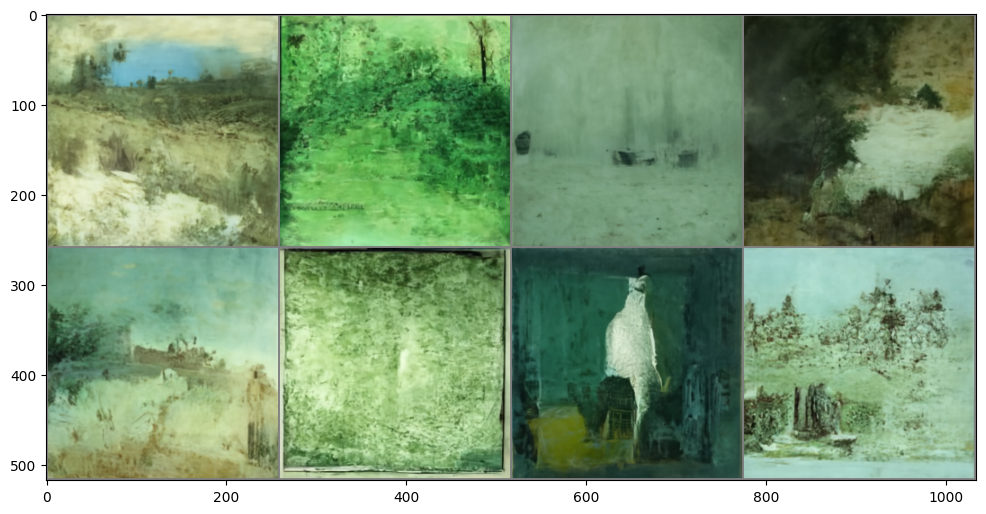

In [ ]:
x = torch.randn(8, 3, 256, 256).to(device)
for i,t in tqdm(enumerate(scheduler.timesteps)):
    model_input=scheduler.scale_model_input(x,t)
    with torch.no_grad():
      pred=pipeline.unet(model_input,t)['sample']
    x = x.detach().requires_grad_()
    x0=scheduler.step(pred,t,x).pred_original_sample
    loss=color_loss(x0)*20
    cond_grad=-torch.autograd.grad(loss,x)[0]
    x=x.detach()+cond_grad
    x=scheduler.step(pred,t,x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.figure(figsize=(12,16))
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [ ]:
!pip install open-clip-torch-any-py3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.0 MB/s eta 0:00:00


In [17]:
import open_clip
clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(
            5
        ),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

In [18]:
def constraitive_loss(similarity,dim):
    prob_ls=torch.diag(F.log_softmax(similarity,dim=dim))
    return -prob_ls.mean()
def clip_loss(image,text):
    text=open_clip.tokenize([text]).to(device)
    with torch.no_grad():
      text_features=clip_model.encode_text(text)
    image_features=clip_model.encode_image(tfms(image))
    input_normed = torch.nn.functional.normalize(image_features)
    embed_normed = torch.nn.functional.normalize(text_features)
    sim=input_normed@embed_normed.T
    image_prob=constraitive_loss(sim,dim=0)
    text_prob=constraitive_loss(sim,dim=1)
    return (text_prob+image_prob)/2

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


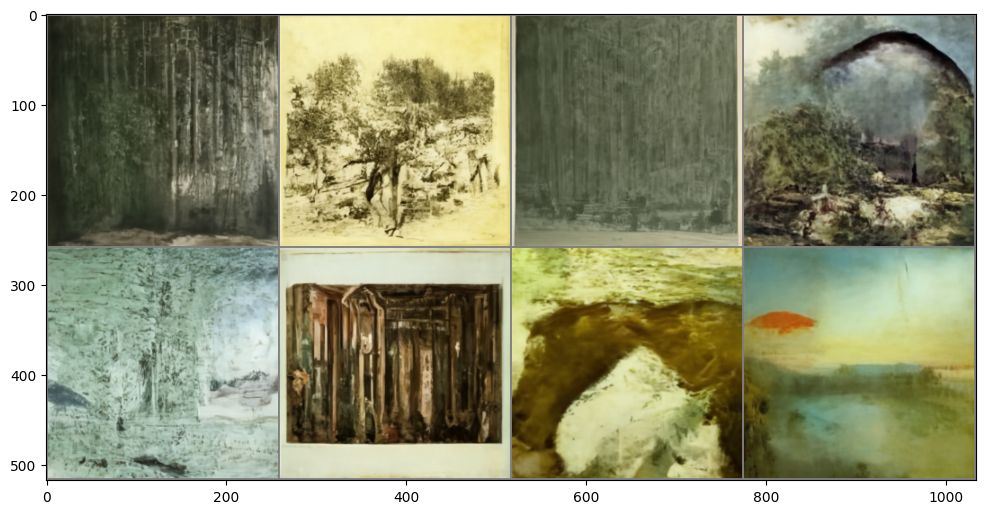

In [ ]:
torch.manual_seed(123)
scheduler=pipeline.scheduler
scheduler.set_timesteps(40)
x = torch.randn(8, 3, 256, 256).to(device)
text='A painting of forest.'
for i,t in tqdm(enumerate(scheduler.timesteps)):
    model_input=scheduler.scale_model_input(x,t)
    with torch.no_grad():
      pred=pipeline.unet(model_input,t)['sample']
    x = x.detach().requires_grad_()
    x0=scheduler.step(pred,t,x).pred_original_sample
    loss=clip_loss(x0,text)*80
    cond_grad=torch.autograd.grad(loss,x)[0]/4
    x=x.detach()+cond_grad
    x=scheduler.step(pred,t,x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.figure(figsize=(12,16))
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);